In [53]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
# visualisation libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns 
%matplotlib  inline

# для нормализации, стандартизации
# 
from sklearn import preprocessing

# Загружаем специальный удобный инструмент для разделения датасета:
# Download utility for dataset split 
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Дополнительные модули для Каггл ноутбука - Additional moduls for Kaggle notebook

In [54]:
# !pip install comet_ml  # for loging
# !pip install textblob  # Sentiment Analysis of short messages
# !pip install nltk # Sentiment Analysis
# !pip install twython  # dependancies for textblob 

### Логируем наши эксперементы - Experiments' loging


In [55]:
from comet_ml import Experiment
# Starting experiment
experiment = Experiment(
    api_key="6Ga3e8coVWoOIpAreIY8DKEgJ",
    project_name="hotels",
    workspace="dekoz",
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/dekoz/hotels/2603f4c24daa4667a49d325e5815efa7
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     figures             : 2
COMET INFO:     filename            : 1
COMET INFO:     git metadata        : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics a

### Основные аргументы - Main arguments

In [56]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
random_state = 42
test_size=0.2
n_estimators = 100
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

### Подгружаем наши данные - Downloading dataset

In [57]:
# Подгрузим наши данные из соревнования

# DATA_DIR = '/kaggle/input/sf-booking/'
DATA_DIR = 'data'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

### Объединяем трейн и тест в один датасет - Merging train part and test part in dataset

In [58]:

df_train['sample'] = 1 # помечаем где у нас трейн train part
df_test['sample'] = 0 # помечаем где у нас тест test part

# в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями
# we don't have information about reviewer_score, so fillna(0)
df_test['reviewer_score'] = 0 

# объединяем merging
data = df_test.append(df_train, sort=False).reset_index(drop=True) 

COMET ERROR: Failed to log git patch


In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

### Обработка даты в строковом формате - Preprooccessing date's string

In [60]:
data['review_date'].head(3)  # month is first

0     7/21/2017
1    12/12/2016
2    11/26/2015
Name: review_date, dtype: object

In [61]:
data['review_date'] = pd.to_datetime(data['review_date'])  # to datetime

data['year'] = data['review_date'].apply(lambda x: x.year)  # extracting year
data['month'] = data['review_date'].apply(lambda x: x.month)  # extracting month
data['day'] = data['review_date'].apply(lambda x: x.day / 31)  # extracting day
data['dow'] = data['review_date'].apply(lambda x: x.isoweekday())  # extracting day of week


### Обработка строки адреса отеля - Preproccessing hotel address string

In [62]:
# Выделяем страну - Extracting country
data['country'] =  data['hotel_address'].apply(lambda x: x.split(sep=' ')[-1] if x.split(' ')[-1] !="Kingdom" else "United Kingdom")
display(data['country'].value_counts(normalize=True))

# Выделяем страну - Extracting country
data['city'] =  data['hotel_address'].apply(lambda x: x.split(sep=' ')[-2] if x.split(' ')[-2] !="United" else "London")
display(data['city'].value_counts(normalize=True))


United Kingdom    0.508594
Spain             0.116627
France            0.116199
Netherlands       0.110936
Austria           0.075502
Italy             0.072143
Name: country, dtype: float64

London       0.508594
Barcelona    0.116627
Paris        0.116199
Amsterdam    0.110936
Vienna       0.075502
Milan        0.072143
Name: city, dtype: float64

In [63]:

city_center = pd.read_csv('data/city_center.csv', sep=';' )
if city_center.columns[0] == "Unnamed: 0":
    city_center.drop('Unnamed: 0', axis=1, inplace= True)
data = data.merge(city_center, how='left', on='city', validate='many_to_one')


In [64]:
# data =  data.groupby("city").transform(lambda x: x.fillna(x.median()))
data = data.fillna(data.groupby("city").transform("median"))


In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 26 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [66]:
data.isna().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
year                                          0
month                                         0
day                                     

In [67]:
%%time
# Вычисляем новый признак: растояние до центра - Calculating new feature: urban distance
from geopy.distance import geodesic
# print (geodesic ((30.28708,120.12802999999997), (28.7427,115.86572000000001)).km)

data['urban_dist'] = data.apply(lambda x: (geodesic((x['lat'], x['lng']), (x['lat_cc'], x['lng_cc'])).km), axis=1)
data['urban_dist']

CPU times: total: 1min 35s
Wall time: 1min 37s


0         7.788060
1         3.978037
2         0.532699
3         1.815149
4         0.394315
            ...   
515733    4.813462
515734    2.710922
515735    1.414063
515736    2.493368
515737    4.794147
Name: urban_dist, Length: 515738, dtype: float64

In [68]:
# data['urban_dist'].to_csv('urban_dist.csv')
# urban_dist = pd.read_csv('urban_dist.csv')
# if "Unnamed: 0" in urban_dist.columns:
#     urban_dist.drop('Unnamed: 0', axis=1, inplace=True)
# data = pd.concat([data, urban_dist ], axis= 1)


### Препроцессинг признака страна ревьюера - Preproccessing reviewer_nationality

In [69]:
data['reviewer_nationality'] = data['reviewer_nationality'].str.strip(' ')

# adding new feature if nationality of reviewer == country of hotel
data['mather_land'] = np.where(data['reviewer_nationality'] == data['country'], 1, 0)


In [70]:
data['reviewer_nationality'].value_counts(normalize=True).head(20).sum()

0.8203622769700895

In [71]:
# выделим 20 наиболее активных национальностей
top_20_nationalities= data['reviewer_nationality'].value_counts().nlargest(20).index
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in top_20_nationalities else 'Other')

### Обработка признака дней с проведения ревью - Preproccessing days_since_review

In [72]:
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split()[0]).astype('int')

In [73]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
stopwords = nltk.corpus.stopwords.words("english") 

# 1st approach add nltk
# MAPE: 13.777297973454605 del lat lng
# MAPE: 12.665555224247374 ntlk 
# # MAPE: 12.665375224247374 del additional_number_of_scoring
senty = SentimentIntensityAnalyzer()
data['nltk_neg'] = data['negative_review'].apply(lambda x: - (senty.polarity_scores(x))["compound"])
data['nltk_pos'] = data['positive_review'].apply(lambda x: (senty.polarity_scores(x))["compound"])
data['nltk_tags'] = data['tags'].apply(lambda x: (senty.polarity_scores(x))["compound"])
# 2nd approach add TextBlob
# MAPE: 13.777297973454605 del lat lng
# MAPE: 12.665555224247374 ntlk 
# MAPE: 12.665375224247374 del additional_number_of_scoring
from textblob import TextBlob
data['blob_neg'] = data['negative_review'].apply(lambda x : (TextBlob(x).sentiment.polarity))
data['blob_pos'] = data['positive_review'].apply(lambda x : (TextBlob(x).sentiment.polarity))
data['blob_tags'] = data['tags'].apply(lambda x : (TextBlob(x).sentiment.polarity))
# MAPE: 13.777297973454605 del lat lng
# MAPE: 13.021613589993034 TextBlob pos & neg separatly
# MAPE: 13.175230494117393 TextBlob sum (pos & neg)

# 3rd approach nltk add TextBlob together
# MAPE: 12.528841994512169 nltk & TextBlob
# add tags.nltk & tags.TextBlob


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Denis.kozarenko\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [74]:
# data[['blob_neg', 'blob_pos', 'blob_tags', 'nltk_neg', 'nltk_pos', 'nltk_tags']].to_csv('data/blob_ntlk.csv')

# nltk_blob = pd.read_csv('data/blob_ntlk.csv')
# if "Unnamed: 0" in nltk_blob.columns:
#     nltk_blob.drop('Unnamed: 0', axis=1, inplace=True)
# data = pd.concat([data, nltk_blob ], axis= 1)
# nltk_blob

### Обработка тэгов - Tags' preproccessing

In [75]:
data['tags'] = data['tags'].apply(lambda x: x[3:-3].split(" ', ' "))

In [76]:
def count_tags(df):
    tag_dict={}
    for tag_list in df:
        for tag in tag_list:
            if tag in tag_dict:
                tag_dict[tag] +=1
            else:
                tag_dict[tag] = 1
    return tag_dict

tag_dict = count_tags(data['tags'])

tag_df = pd.DataFrame(tag_dict.items(), columns=['tags', 'count']).sort_values('count', ascending=False)
tag_df['count'][:19].sum() / tag_df['count'].sum() *100


83.91626552241543

In [77]:
top_tag_list = tag_df['tags'][:19].tolist()
# закодируем признак tags
for tag in top_tag_list:
    data[tag] = data['tags'].apply(lambda x: 1 if tag in x else 0)


### Новый признак отклонение % оценок без проверки от общего количества

In [78]:
data['tr_share'] = data['additional_number_of_scoring'] / data['total_number_of_reviews']

{'web': 'https://www.comet.ml/api/image/download?imageId=2ed507cad19e449280571eca8de319a1&experimentKey=e9bcef35ee9b4d41bdb9bd8d61ea4eb1',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=2ed507cad19e449280571eca8de319a1&experimentKey=e9bcef35ee9b4d41bdb9bd8d61ea4eb1',
 'imageId': '2ed507cad19e449280571eca8de319a1'}

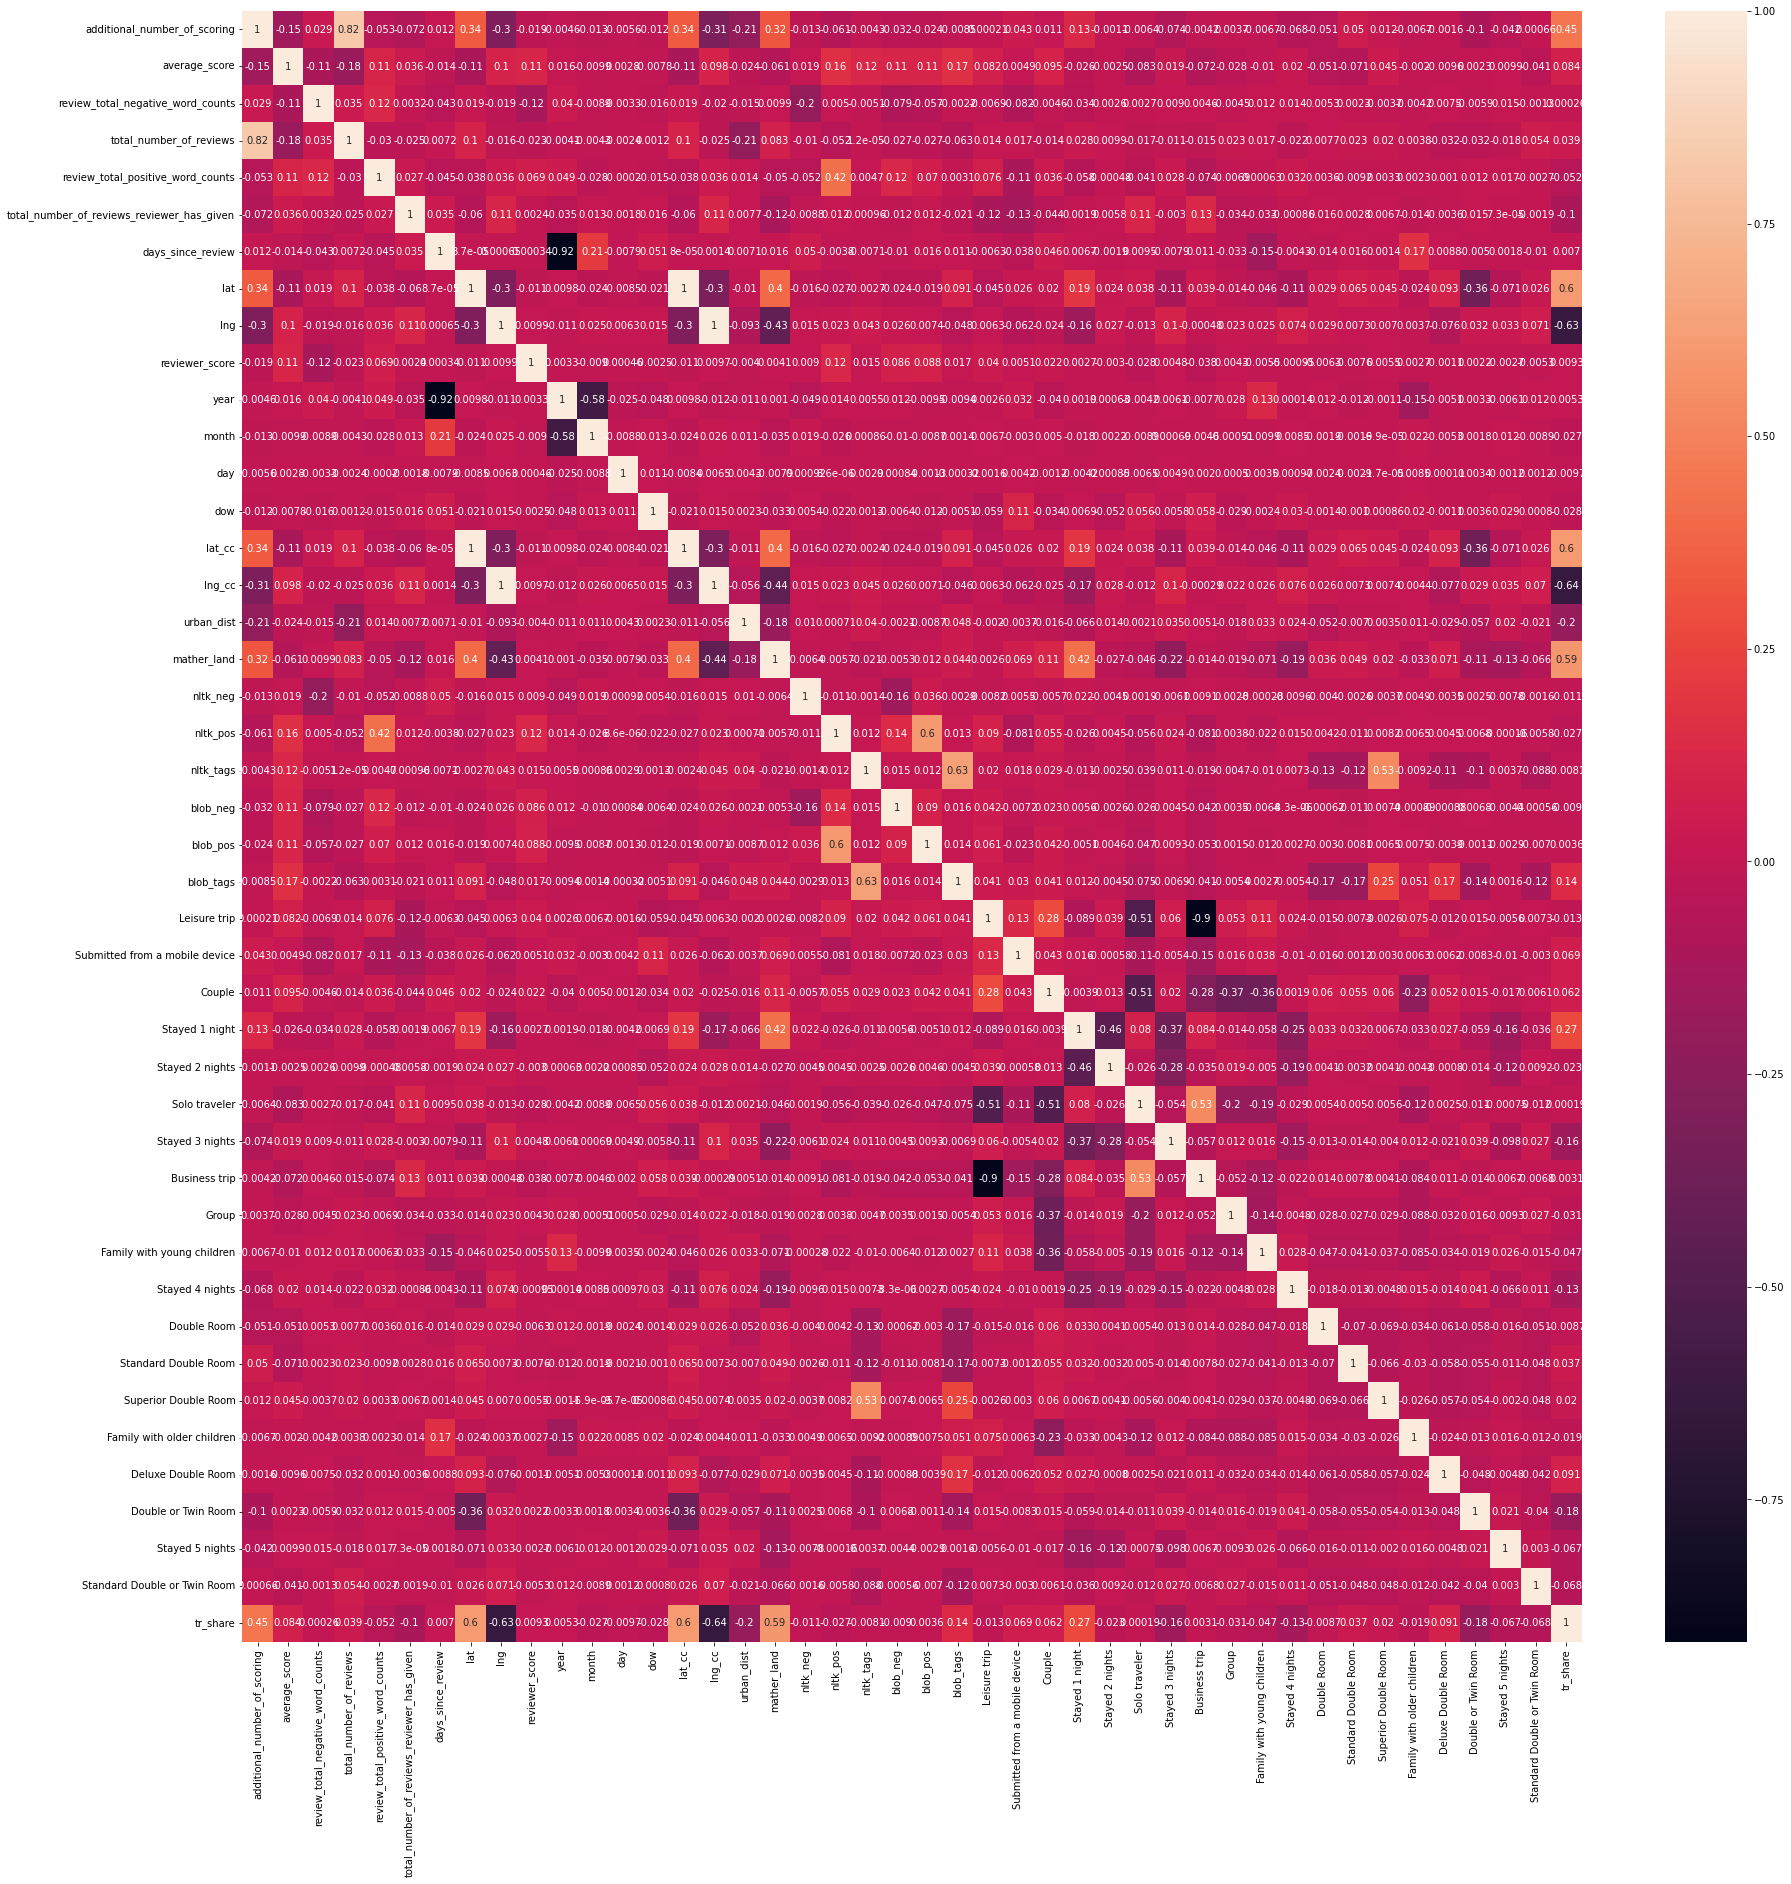

In [79]:
plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)
experiment.log_figure()

In [80]:
categorical_columns_names = ['year', 'country', 'dow']
data = pd.get_dummies(data, columns = categorical_columns_names)
# MAPE: 12.467861978966885 OneHotEncoding 

from sklearn.preprocessing import LabelEncoder
# import category_encoders as ce
# creating instance of labelencoder
encoder = LabelEncoder()
# # encoder = ce.HashingEncoder()
# # Assigning numerical values and storing in another column
data['reviewer_nationality'] = encoder.fit_transform(data['reviewer_nationality'])
data['month'] = encoder.fit_transform(data['month'])
# MAPE: 12.42523039953605 label encoder reviewer_nationality 
# MAPE: 12.404010271383388 OneHotEncoding reviewer_nationality 
# MAPE: 12.465436390466763 PolynomialEncoder reviewer_nationality 
# MAPE: 12.460527000104966 ce.HashingEncoder reviewer_nationality


In [81]:
 data.info()
 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  int32         
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [82]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = list(data.select_dtypes(include='object').columns) #[s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)
data.drop('review_date', axis = 1, inplace=True)
data.drop('lat_cc', axis = 1, inplace=True)
data.drop('lng_cc', axis = 1, inplace=True)

In [83]:
 data.info()
 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 58 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   reviewer_nationality                        515738 non-null  int32  
 3   review_total_negative_word_counts           515738 non-null  int64  
 4   total_number_of_reviews                     515738 non-null  int64  
 5   review_total_positive_word_counts           515738 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 7   days_since_review                           515738 non-null  int32  
 8   lat                                         515738 non-null  float64
 9   lng                                         515738 non-null  float64
 

{'web': 'https://www.comet.ml/api/image/download?imageId=70eb2f1ccf364a708dc74976cd165df0&experimentKey=e9bcef35ee9b4d41bdb9bd8d61ea4eb1',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=70eb2f1ccf364a708dc74976cd165df0&experimentKey=e9bcef35ee9b4d41bdb9bd8d61ea4eb1',
 'imageId': '70eb2f1ccf364a708dc74976cd165df0'}

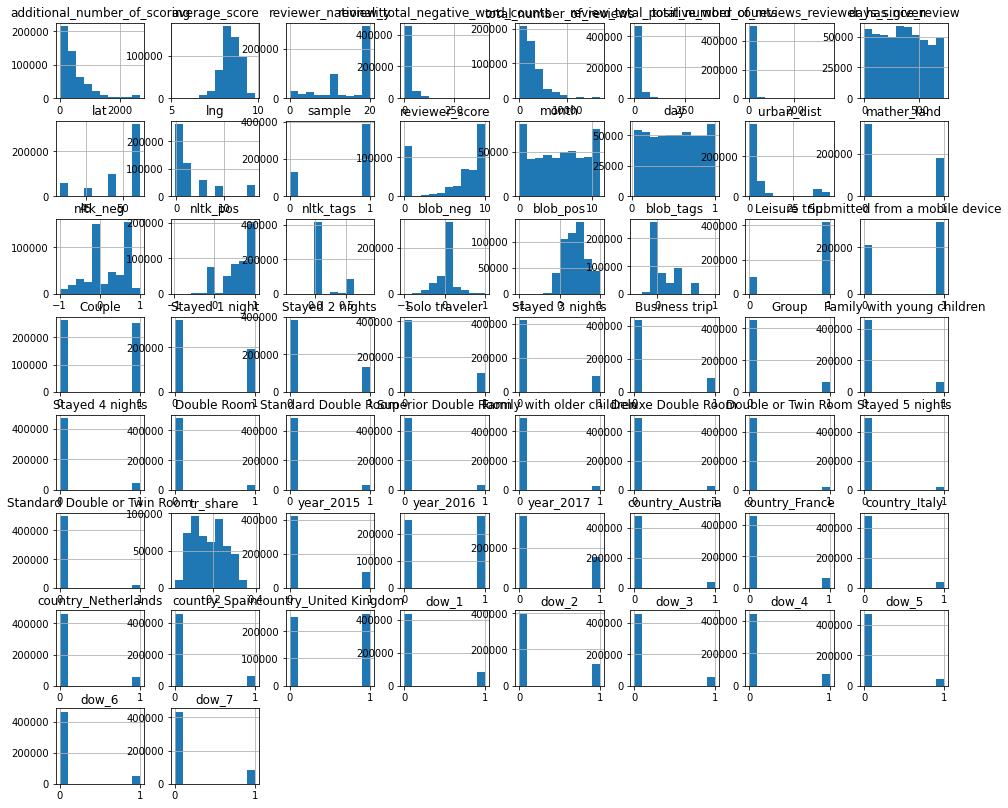

In [84]:
data.hist(figsize=(16,14));
#логируем гистограмму
experiment.log_figure()


In [85]:
data.columns

Index(['additional_number_of_scoring', 'average_score', 'reviewer_nationality',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'lat', 'lng', 'sample', 'reviewer_score', 'month', 'day', 'urban_dist',
       'mather_land', 'nltk_neg', 'nltk_pos', 'nltk_tags', 'blob_neg',
       'blob_pos', 'blob_tags', 'Leisure trip',
       'Submitted from a mobile device', 'Couple', 'Stayed 1 night',
       'Stayed 2 nights', 'Solo traveler', 'Stayed 3 nights', 'Business trip',
       'Group', 'Family with young children', 'Stayed 4 nights', 'Double Room',
       'Standard Double Room', 'Superior Double Room',
       'Family with older children', 'Deluxe Double Room',
       'Double or Twin Room', 'Stayed 5 nights',
       'Standard Double or Twin Room', 'tr_share', 'year_2015', 'year_2016',
       'year_2017', 'country_Austria', 'country_France', 'country

In [86]:
# числовые признаки
num_cols = ['additional_number_of_scoring', 'average_score', 
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'days_since_review',
       'lat', 'lng', 'urban_dist', 'blob_neg', 'blob_pos', 'blob_tags', 'nltk_neg', 'nltk_pos',
       'nltk_tags', 'tr_share']

# категориальные признаки
cat_cols = ['reviewer_nationality', 'mather_land',
       'Leisure trip', 'Submitted from a mobile device', 'Couple',
       'Stayed 1 night', 'Stayed 2 nights', 'Solo traveler', 'Stayed 3 nights',
       'Business trip', 'Group', 'Family with young children',
       'Stayed 4 nights', 'Double Room', 'Standard Double Room',
       'Superior Double Room', 'Family with older children',
       'Deluxe Double Room', 'Double or Twin Room', 'Stayed 5 nights',
       'Standard Double or Twin Room', 'year_2015', 'year_2016',
       'year_2017', 'month', 'country_Austria', 'country_France', 'country_Italy',
       'country_Netherlands', 'country_Spain', 'country_United Kingdom',
       'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'dow_7']

<AxesSubplot:>

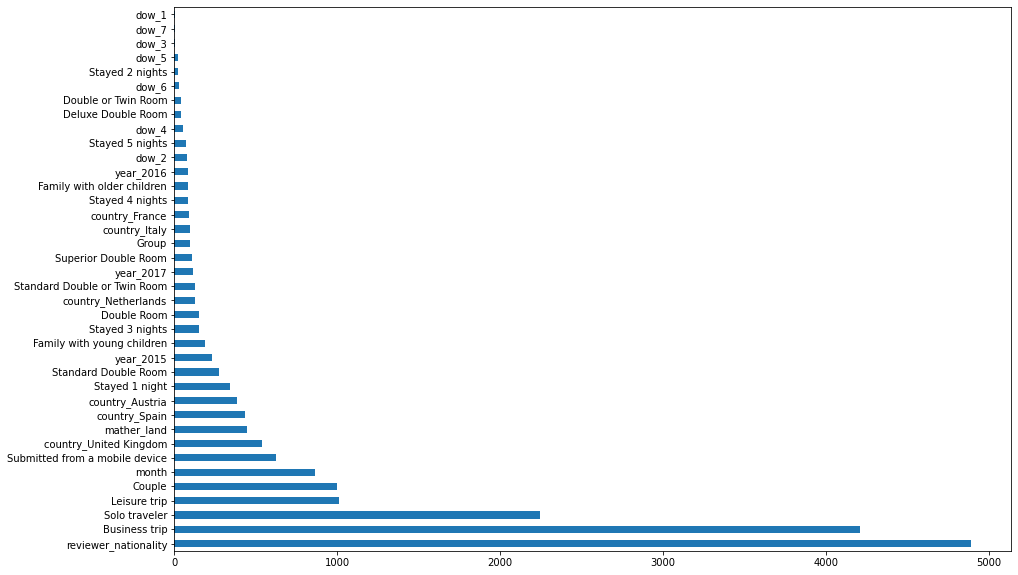

In [87]:
from sklearn.feature_selection import chi2 # хи-квадрат

# для оценки значимости категориальных переменных будем использовать непараметрический тест хи-квадрат.
# выведем значения хи-квадрат на графике:

y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = data.query('sample == 1').drop(['sample'], axis=1)[cat_cols]

plt.rcParams['figure.figsize'] = (15,10)
imp_cat = pd.Series(chi2(X, y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True, ascending=False)
imp_cat.plot(kind = 'barh')

In [88]:
display(imp_cat)
drop_list = imp_cat.index[20:].tolist()
data = data.drop(drop_list, axis=1)

reviewer_nationality              4891.678906
Business trip                     4207.179471
Solo traveler                     2247.654889
Leisure trip                      1010.958848
Couple                            1001.181753
month                              863.598743
Submitted from a mobile device     625.486638
country_United Kingdom             537.769510
mather_land                        445.657773
country_Spain                      433.015396
country_Austria                    386.177065
Stayed 1 night                     341.401043
Standard Double Room               272.725210
year_2015                          230.588642
Family with young children         187.215152
Stayed 3 nights                    152.886817
Double Room                        151.675618
country_Netherlands                130.662870
Standard Double or Twin Room       126.604877
year_2017                          117.466609
Superior Double Room               109.320258
Group                             

<AxesSubplot:>

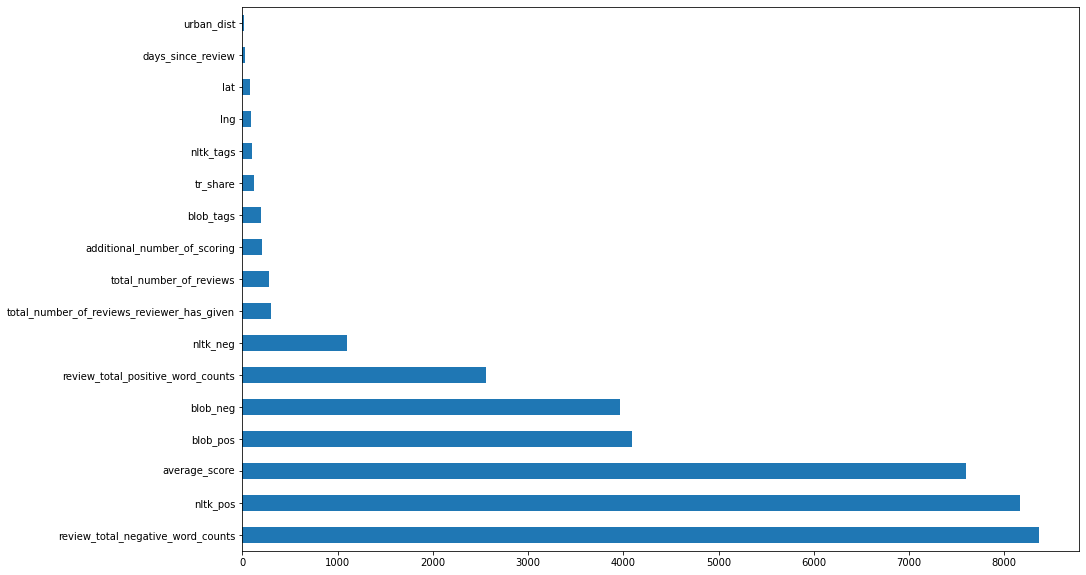

In [89]:
from sklearn.feature_selection import f_classif # anova
# Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn.
# В основе метода оценки значимости переменных лежит анализ (ANOVA).
# В качестве меры значимости будем использовать значение f-статистики - чем значение статистики выше, тем меньше 
# вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели.

y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = data.query('sample == 1').drop(['sample'], axis=1)[num_cols]

imp_num = pd.Series(f_classif(X, y)[0], index = num_cols)
imp_num.sort_values(inplace = True, ascending=False)
imp_num.plot(kind = 'barh')

In [90]:
drop_list = imp_num.index[13:].to_list()
data = data.drop(drop_list, axis=1)

In [91]:
# чтобы исключить мультиколлениарность удалим признаки, сильно коррелирующие с другими признаками
pivot = data.corr()
pivot = pivot.drop('sample', axis=0)
pivot = pivot.drop('sample', axis=1)
for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.65 or x == 1) else x)
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')
fig = px.imshow(pivot)
fig.show()

# постараемся удалить минимальное количество признаков - удаляем признаки с максимальной корреляцией
counter = 0
for lower_bound in np.linspace(0.98, 0.75, num=14):
    for col in pivot:
        if pivot[col].max() > lower_bound or pivot[col].min() < -lower_bound:
            pivot = pivot.drop(col, axis=0)
            pivot = pivot.drop(col, axis=1)
            data = data.drop(col, axis=1)
            counter += 1
print('Deleted', counter, 'columns')

Deleted 3 columns


<AxesSubplot:>

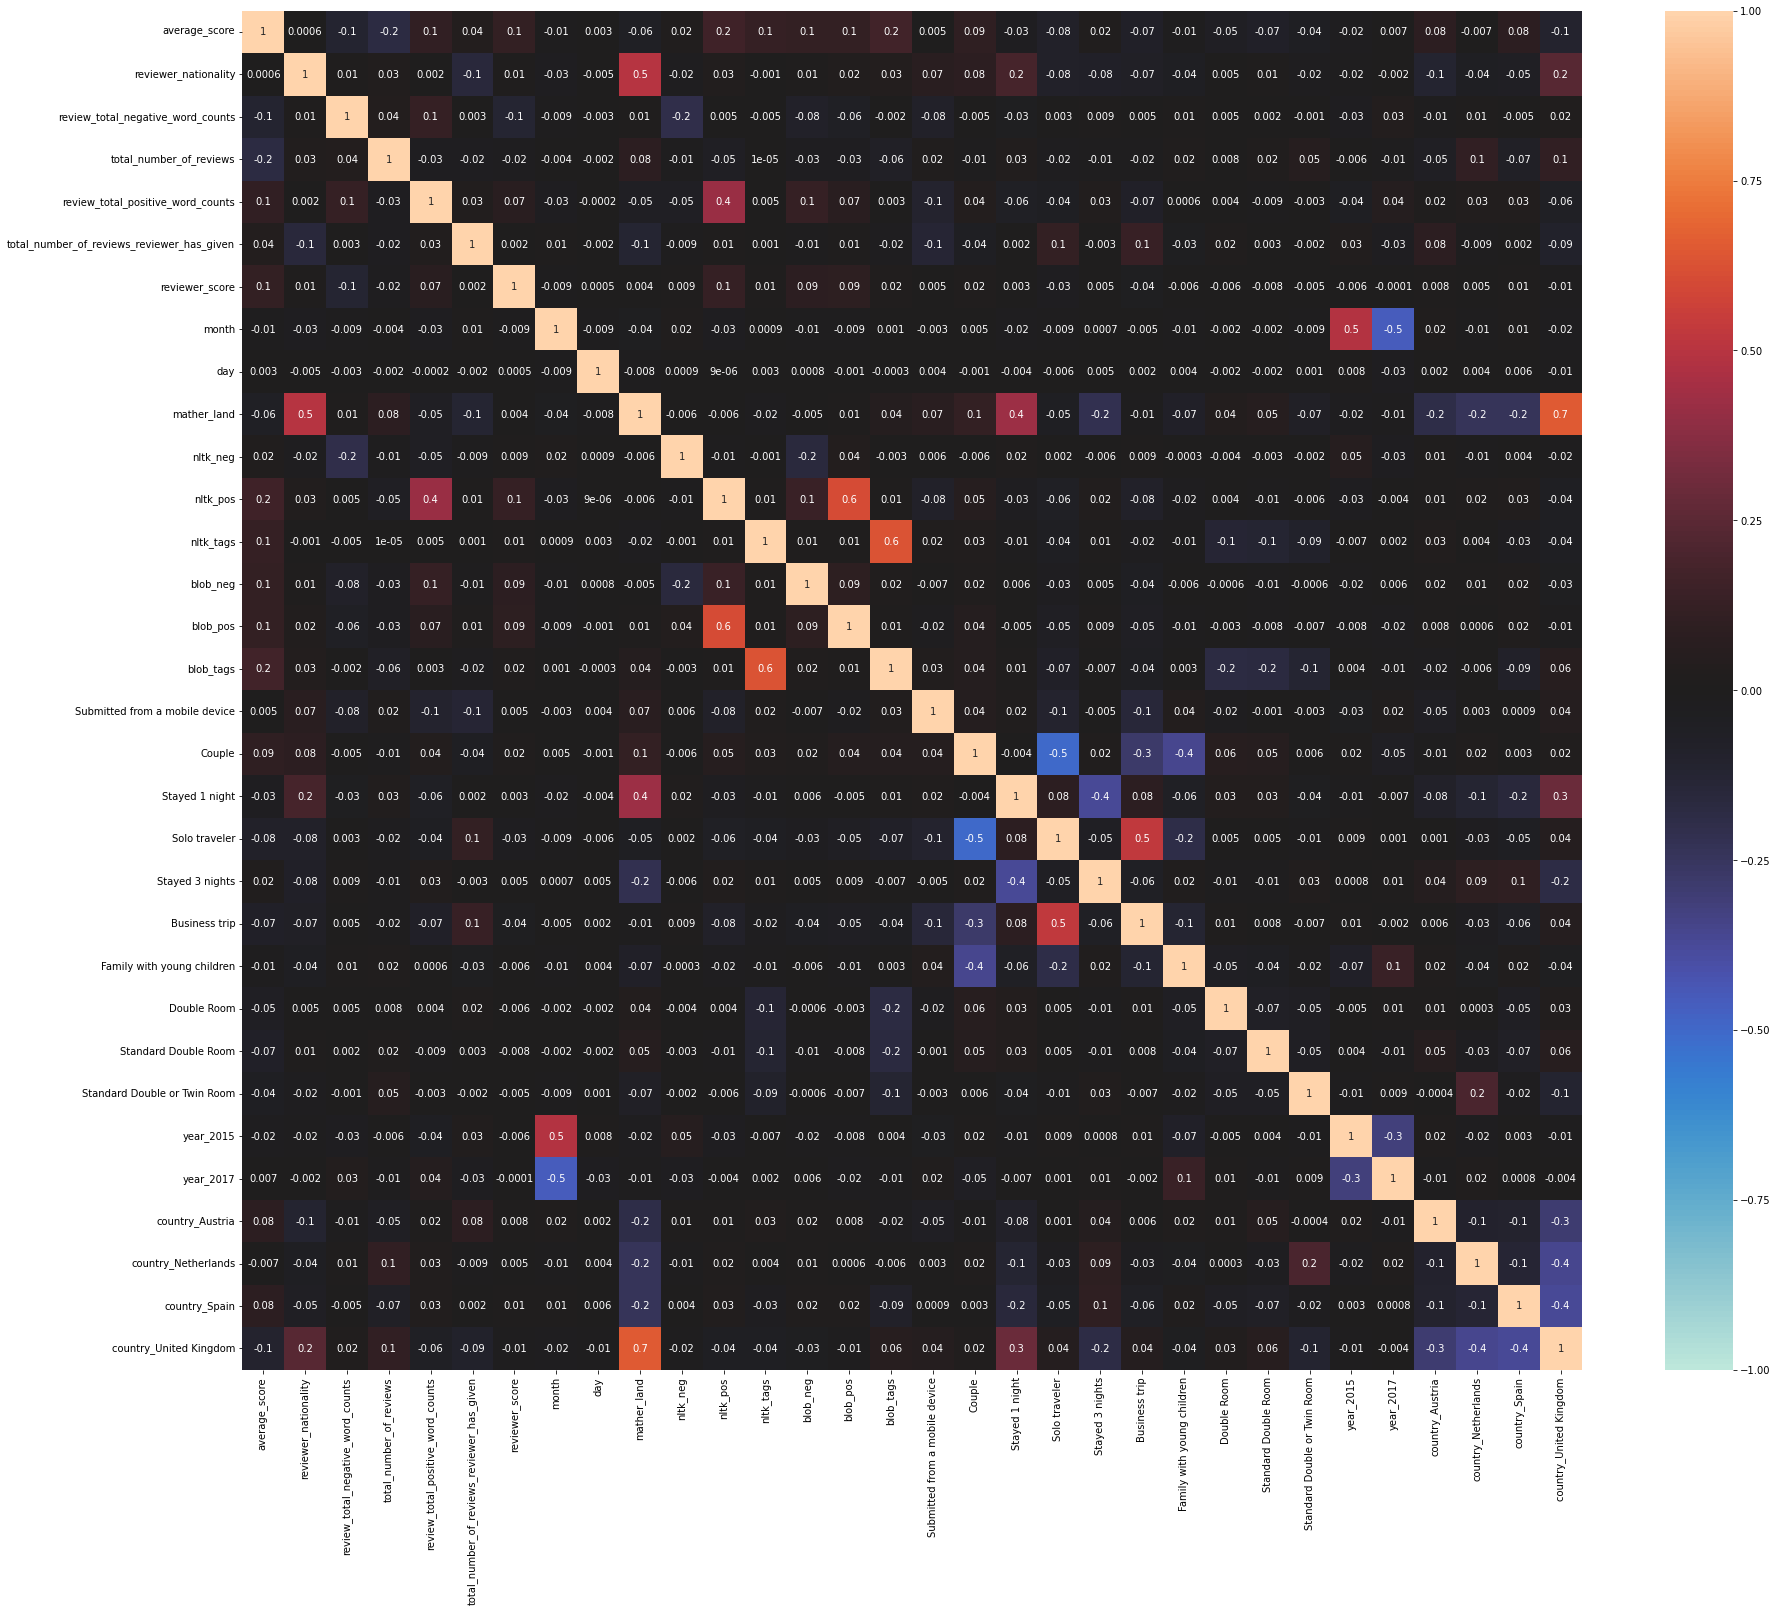

In [92]:
# проверяем тепловую карту корреляции на предмет оставших сильно скоррелированных признаков
plt.rcParams['figure.figsize'] = (30,25)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True, vmin=-1, vmax=1, center= 0, fmt='.1g')

### Подготовка данных

In [93]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [94]:
params={"random_state":random_state, 
        "n_estimators":n_estimators,
        "test_size": test_size,
        "encoder": encoder,
 
}
experiment.log_parameters(params)

In [95]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [96]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 32), (386803, 32), (386803, 31), (309442, 31), (77361, 31))

In [97]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [98]:
n_estimators = 100

In [99]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=n_estimators, verbose=1, n_jobs=-1, random_state=random_state)

In [100]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.2s finished


In [101]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# 
import numpy as np
 
# Функция для вычисления MAPE
def mape_func(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape
mape = mape_func(y_test, y_pred)
#mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
print('MAPE:', mape)
metric = {'MAPE': mape}
# MAPE: 14.5 Start
# MAPE: 13.8 date_string to year month day columns
# MAPE: 13.777297973454605 del lat lng
# MAPE: 12.665555224247374 ntlk or MAPE: 13.021613589993034 TextBlob separatly or MAPE: 13.175230494117393 TextBlob sum
# MAPE: 12.665375224247374 del additional_number_of_scoring
# MAPE: 12.528841994512169 ntlk & TextBlob
# MAPE: 12.517222320394728 add tags ntlk & TextBlob
# MAPE: 12.468527368697334 OneHotEncoding year month day columns
# MAPE: 12.42523039953605 category encoding nationality
# MAPE: 12.404010271383388 OneHotEncoding nationality +240 seconds per 230 nations
# MAPE: 12.400370223616509 add country and day of week
# MAPE: 12.429135654511606 add urban distance and reduce number of reveiwer nations add tags & DOW OHE


MAPE: 12.414608819425409


{'web': 'https://www.comet.ml/api/image/download?imageId=e3d7e86af8464ead957e3c0538930252&experimentKey=e9bcef35ee9b4d41bdb9bd8d61ea4eb1',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=e3d7e86af8464ead957e3c0538930252&experimentKey=e9bcef35ee9b4d41bdb9bd8d61ea4eb1',
 'imageId': 'e3d7e86af8464ead957e3c0538930252'}

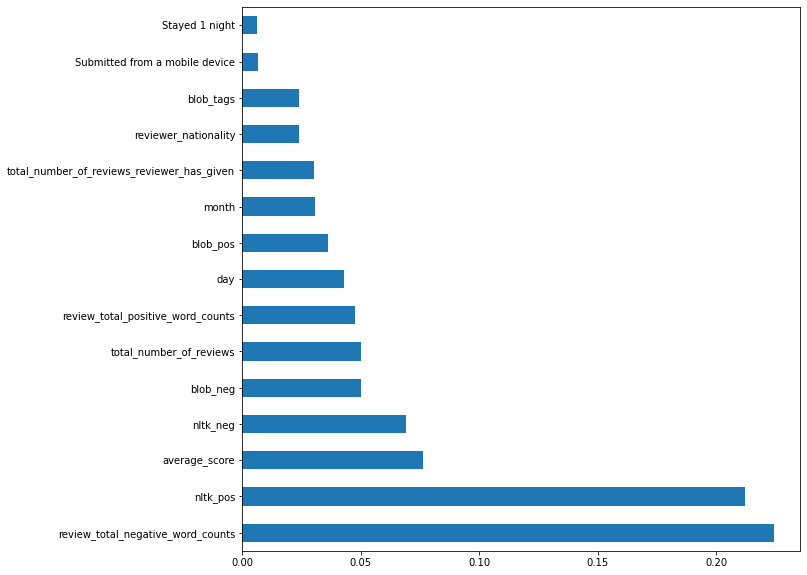

In [102]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
experiment.log_figure()

In [103]:
test_data.sample(10)

,average_score,reviewer_nationality,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,month,day,mather_land,...,Family with young children,Double Room,Standard Double Room,Standard Double or Twin Room,year_2015,year_2017,country_Austria,country_Netherlands,country_Spain,country_United Kingdom
69443,8.8,11,42,3598,18,31,0.0,11,0.677419,0,...,1,1,0,0,1,0,1,0,0,0
14660,8.7,10,0,7656,52,34,0.0,11,0.677419,0,...,0,0,0,0,1,0,0,1,0,0
8371,8.6,19,3,1082,3,2,0.0,2,0.419355,1,...,0,0,0,0,0,1,0,0,0,1
84462,7.5,10,12,3811,10,9,0.0,1,0.677419,0,...,0,1,0,0,0,0,0,0,0,0
86948,8.7,9,21,12158,9,1,0.0,2,0.096774,0,...,0,0,0,0,0,0,0,0,0,1
103561,9.1,17,3,909,18,11,0.0,10,0.387097,0,...,0,0,0,0,0,0,0,1,0,0
62743,8.8,13,0,478,11,1,0.0,3,0.483871,0,...,1,0,1,0,0,1,0,0,0,1
79460,8.7,19,49,1416,20,1,0.0,4,0.870968,0,...,0,1,0,0,0,0,0,0,1,0
100723,8.0,10,11,2418,3,19,0.0,6,0.354839,0,...,1,0,0,0,0,1,0,0,0,1
8981,9.1,18,0,501,28,17,0.0,0,0.258065,0,...,1,0,0,0,0,1,0,0,0,1


In [104]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [105]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [106]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.1s finished


In [107]:
predict_submission

array([8.696, 7.16 , 8.715, ..., 8.108, 9.311, 7.146])

In [108]:
list(sample_submission)

['reviewer_score', 'id']

In [109]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission_country.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.696,488440
1,7.160,274649
2,8.715,374688
3,9.753,404352
4,9.644,451596
5,8.699,302161
6,8.423,317079
7,7.412,13963
8,8.493,159785
9,7.568,195089


In [110]:
experiment.log_metrics(metric)

In [111]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/dekoz/hotels/e9bcef35ee9b4d41bdb9bd8d61ea4eb1
COMET INFO:   Metrics:
COMET INFO:     MAPE : 12.414608819425409
COMET INFO:   Parameters:
COMET INFO:     bootstrap                : True
COMET INFO:     ccp_alpha                : 0.0
COMET INFO:     criterion                : squared_error
COMET INFO:     encoder                  : LabelEncoder()
COMET INFO:     max_depth                : 1
COMET INFO:     max_features             : 1.0
COMET INFO:     max_leaf_nodes           : 1
COMET INFO:     max_samples              : 1
COMET INFO:     min_impurity_decrease    : 0.0
COMET INFO:     min_samples_leaf         : 1
COMET INFO:     min_samples_split        : 2
COMET INFO:     min_weight_fraction_leaf : 0.0
COMET INFO:     n_estimators             : 1